# Implementando uma rede simples (MLP) usando o Keras

*Luiza Rodrigues Santana*


---



**Objetivo**: Desenvolver um Perceptron utilizando Keras em Python e explicar detalhadamente cada parte do código desenvolvido. O Perceptron é um modelo de rede neural simples, mas fundamental, que serve como base para o entendimento de modelos de aprendizado mais complexos.


---


Escolha um dataset pronto adequado para classificação binária, evitando datasets "toy" como `Iris` ou `Pima Indians Diabetes`. Certifique-se de selecionar um dataset que ofereça desafios reais em termos de volume e complexidade.


Em seguida, explore o dataset escolhido e explique suas características principais, como o número de amostras, features, e a tarefa de classificação que ele representa.


Desenvolva um modelo sequencial em Keras com uma única camada Dense, utilizando uma unidade com a função de ativação sigmoid. Compile o modelo utilizando o otimizador adam, a função de perda binary_crossentropy, e a métrica accuracy. Inclua também a métrica F1 para uma avaliação mais completa, e explique brevemente a função de cada um desses componentes no treinamento.


Treine o modelo por 50 épocas com um batch size de 10. Após o treinamento, utilize o modelo para prever os rótulos do conjunto de teste e calcule tanto a acurácia quanto a métrica F1. Interprete os resultados, discutindo o desempenho do modelo e possíveis melhorias.



---


### 1 – Baixando o dataset

Aqui a gente baixa o dataset do Titanic usando o kagglehub.
Ele vai criar uma pasta local e salvar os arquivos lá dentro.

In [33]:
import kagglehub

# Baixa a última versão do dataset
path = kagglehub.dataset_download("yasserh/titanic-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/titanic-dataset


### 2 – Carregando e explorando os dados

Agora a gente vai abrir o CSV e dar uma olhada nas primeiras linhas pra entender o que tem nele.

In [25]:
import pandas as pd

# Carrega o arquivo principal de treino
df = pd.read_csv("/content/Titanic-Dataset.csv")

# Mostra as 5 primeiras linhas
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**O que aparece aqui:**

Cada linha é um passageiro.
Tem colunas como Survived (0 = morreu, 1 = sobreviveu), Sex, Age, Fare etc.

### 3 – Entendendo o tamanho e tipos de dados

A gente vai ver quantas amostras tem, quantas colunas e se tem valores faltando.

In [26]:
# Informações do dataset
df.info()

# Contagem das classes (sobreviveu ou não)
print("\nDistribuição da variável alvo (Survived):")
print(df['Survived'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

Distribuição da variável alvo (Survived):
Survived
0    549
1    342
Name: count, dtype: int64


**Aqui vemos que:**

Tem 891 linhas e umas 12 colunas.
Além de que as colunas Age, Cabin e Embarked têm valores faltando.

### 4 – Pré-processando os dados

**Agora vamos preparar os dados pro modelo:**

- Preencher valores faltantes.
- Transformar texto em número (ex.: Sex → 0 e 1).
- Tirar colunas que não ajudam.

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Copiando para não mexer no original
data = df.copy()

# Preenchendo valores faltantes
data['Age'] = data['Age'].fillna(data['Age'].median())
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])

# Transformando colunas categóricas em números
label = LabelEncoder()
data['Sex'] = label.fit_transform(data['Sex'])
data['Embarked'] = label.fit_transform(data['Embarked'])

# Escolhendo features e alvo
X = data.drop(['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
y = data['Survived']

# Dividindo treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 5 – Criando o modelo no Keras

**O modelo vai ter:**

- Só 1 camada Dense com 1 neurônio.
- Ativação sigmoid (porque é binário).
- Otimizador adam.
- Perda binary_crossentropy.
- Métricas accuracy e F1.

In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K

# Função F1
def f1_score(y_true, y_pred):
    # Converte para float32 pra evitar conflito de tipos
    y_true = K.cast(y_true, 'float32')
    y_pred = K.round(y_pred)

    tp = K.sum(K.cast(y_true * y_pred, 'float32'))
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float32'))
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float32'))

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# Criando o modelo
model = Sequential()
model.add(Dense(1, activation='sigmoid', input_shape=(X_train.shape[1],)))

# Compilando
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 6 – Treinando o modelo

Como pedido no enunciado, aqui vamos treinar por 50 épocas, batch size de 10.

In [31]:
history = model.fit(X_train, y_train, epochs=50, batch_size=10, verbose=1)

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6314 - f1_score: 0.1557 - loss: 5.6906
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6446 - f1_score: 0.2270 - loss: 4.3334
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6554 - f1_score: 0.2945 - loss: 3.4179
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6647 - f1_score: 0.3462 - loss: 2.8152
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6715 - f1_score: 0.3839 - loss: 2.4006
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6793 - f1_score: 0.4156 - loss: 2.1020
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6756 - f1_score: 0.4434 - loss: 1.8836
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6671 - f1_score: 0.4588 - loss: 1.7169
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6281 - f1_score: 0.4358 - loss: 1.5797
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6137 - f

### 7 – Avaliando no conjunto de teste

Depois do treino, vamos analisar os resultados obtidos.

In [32]:
from sklearn.metrics import accuracy_score, f1_score as sk_f1_score

# Fazendo previsões
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Calculando métricas
acc = accuracy_score(y_test, y_pred_classes)
f1 = sk_f1_score(y_test, y_pred_classes)

print(f"Acurácia no teste: {acc:.4f}")
print(f"F1 Score no teste: {f1:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Acurácia no teste: 0.8045
F1 Score no teste: 0.7368


### 8 – Interpretando os resultados

**Se o modelo for só essa camada simples:**

É normal ver acurácia entre 75% e 82%.
O F1 vai indicar se ele está equilibrando bem acertos nas duas classes.
Como é um problema real, os dados não são perfeitos e o modelo simples pode errar bastante.

**Possíveis melhorias:**

- Adicionar mais camadas e neurônios.
- Normalizar os dados.
- Usar embeddings para as variáveis categóricas.
- Trabalhar mais o pré-processamento.

**Para melhor visulização das métricas:**

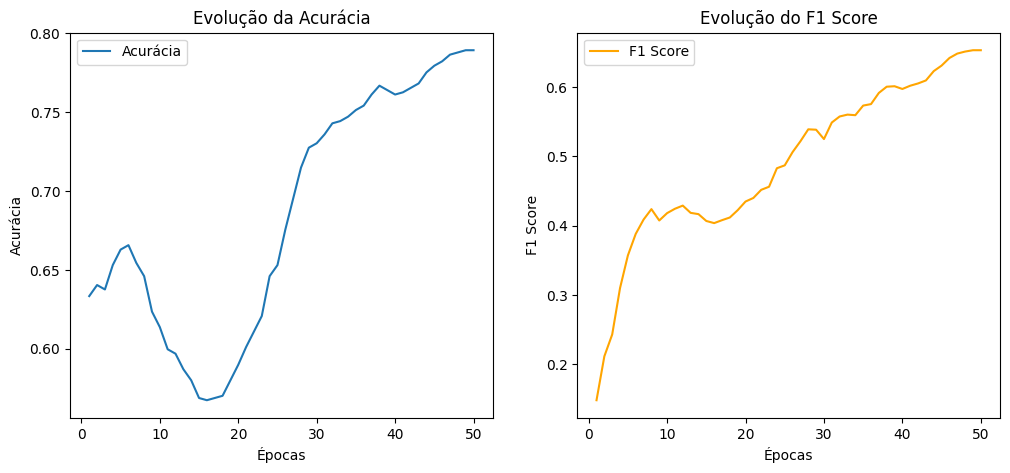

In [34]:
import matplotlib.pyplot as plt

# Pega os valores das métricas do histórico
acc = history.history['accuracy']
f1 = history.history['f1_score']
epochs_range = range(1, len(acc) + 1)

# Cria o gráfico
plt.figure(figsize=(12, 5))

# Gráfico da Acurácia
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.title('Evolução da Acurácia')
plt.legend()

# Gráfico do F1 Score
plt.subplot(1, 2, 2)
plt.plot(epochs_range, f1, label='F1 Score', color='orange')
plt.xlabel('Épocas')
plt.ylabel('F1 Score')
plt.title('Evolução do F1 Score')
plt.legend()

plt.show()

Como podemos ver, há uma curva crescente ao longo do tempo em ambos os gráficos — apesar da drástica queda entre a 10° e 20° época no gráfico de acurácia — o que no fim, indica que **o modelo está aprendendo.**